## Setup

In [1]:
from IPython.display import clear_output; token = input(); clear_output()

In [2]:
! git clone https://$token@github.com/SzymonLukasik/Deep4Life.git

Cloning into 'Deep4Life'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 120 (delta 53), reused 105 (delta 39), pack-reused 0
Receiving objects: 100% (120/120), 17.85 MiB | 19.45 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [3]:
%cd /content/Deep4Life

/content/Deep4Life


In [8]:
!pip install anndata

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 3.7 MB/s eta 0:00:00


In [6]:
! pip install pyometiff

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 33.8 MB/s eta 0:00:00


## Imports

In [51]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import pyometiff
import os
import gdown
import json
from pathlib import Path
from sklearn.preprocessing import LabelEncoder

from typing import List
from src.datasets import load_d4ls
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

In [4]:
%load_ext autoreload
%autoreload 2

In [10]:
!mkdir data

In [11]:
!gdown 1-0YOHE1VoTRWqfBJLHQorGcHmkhCYvqW

Downloading...
From (original): https://drive.google.com/uc?id=1-0YOHE1VoTRWqfBJLHQorGcHmkhCYvqW
From (redirected): https://drive.google.com/uc?id=1-0YOHE1VoTRWqfBJLHQorGcHmkhCYvqW&confirm=t&uuid=6ef28656-09bc-429c-88e5-f7402bce8de4
To: /content/Deep4Life/train.zip
100% 843M/843M [00:25<00:00, 33.3MB/s]


In [12]:
load_d4ls.DATA_PATH

PosixPath('/content/Deep4Life/data')

In [ ]:
!unzip train.zip -d $load_d4ls.DATA_PATH

## Load anndata

In [14]:
train_anndata = load_d4ls.load_full_anndata()

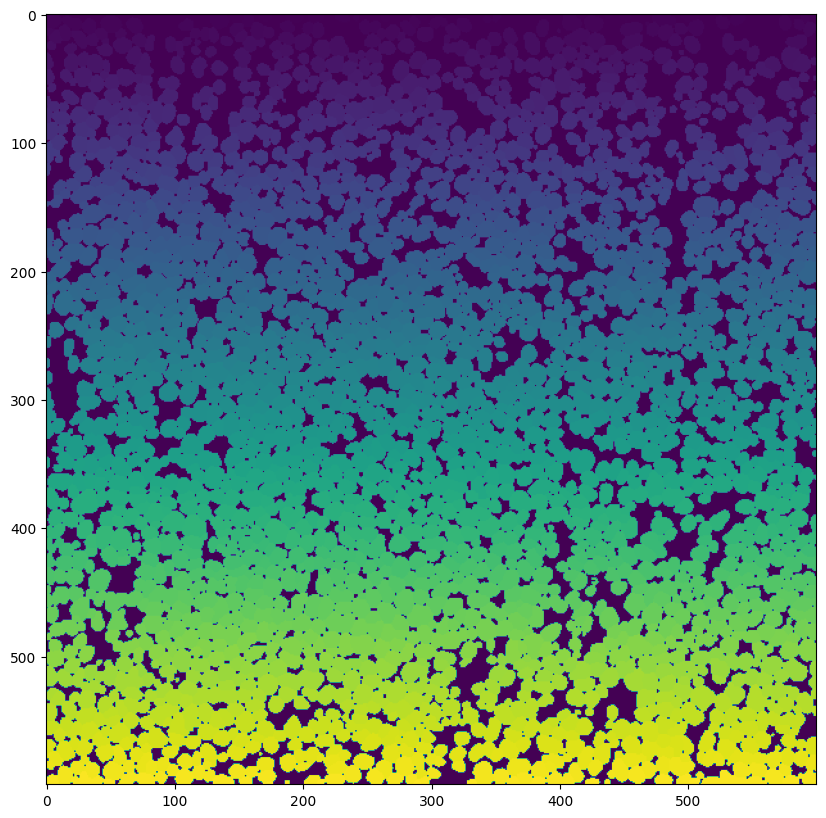

In [15]:
image_name = train_anndata.obs.iloc[2]['image']
image_path = os.path.join(load_d4ls.TRAIN_IMAGE_DATA_IMAGES, image_name)
mask_path = os.path.join(load_d4ls.TRAIN_IMAGE_DATA_MASKS, image_name)

image_reader = pyometiff.OMETIFFReader(fpath=image_path)
mask_reader = pyometiff.OMETIFFReader(fpath=mask_path)

image_array, _, _ = image_reader.read()
mask_array, _, _ = mask_reader.read()

# mask has 1 channel with values higher than 255 - each pixel is an object_id
# to properly visualize it we need to apply colormap

def apply_colormap(mask_array: np.ndarray) -> np.ndarray:
    # unique_ids = np.unique(mask_array)
    # colormap = plt.cm.get_cmap('tab20', len(unique_ids))
    # colored_mask = colormap(mask_array)

    colored_mask = mask_array / np.max(mask_array)
    return colored_mask

colored_mask = apply_colormap(mask_array)

plt.figure(figsize=(10, 10))
plt.imshow(colored_mask)
# add legend
# plt.colorbar(ticks=np.linspace(0, 1, len(np.unique(mask_array))))

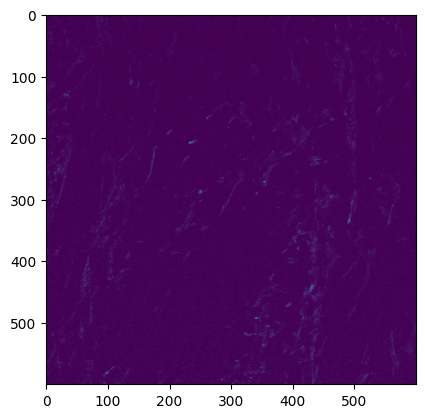

In [16]:
plt.imshow(image_array[2])

In [103]:
image_array.shape

(40, 600, 600)

In [104]:
mask_array.shape

(600, 600)

In [118]:
# check shapes of all images and masks
image_shapes = set()
mask_shapes = set()

for image_name in train_anndata.obs['image'].unique():
    image_path = os.path.join(load_d4ls.TRAIN_IMAGE_DATA_IMAGES, image_name)
    mask_path = os.path.join(load_d4ls.TRAIN_IMAGE_DATA_MASKS, image_name)

    image_reader = pyometiff.OMETIFFReader(fpath=image_path)
    mask_reader = pyometiff.OMETIFFReader(fpath=mask_path)

    image_array, _, _ = image_reader.read()
    mask_array, _, _ = mask_reader.read()

    image_shapes.add(image_array.shape)
    mask_shapes.add(mask_array.shape)


In [119]:
image_shapes, mask_shapes

({(40, 400, 500),
  (40, 500, 500),
  (40, 500, 600),
  (40, 530, 530),
  (40, 550, 641),
  (40, 600, 599),
  (40, 600, 600)},
 {(400, 500),
  (500, 500),
  (500, 600),
  (530, 530),
  (550, 641),
  (600, 599),
  (600, 600)})

## CellSighter

In [17]:
! git clone https://$token@github.com/SzymonLukasik/CellSighter.git ../CellSighter
! git checkout lukass/baseline_experiment

Cloning into '../CellSighter'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 74 (delta 31), reused 56 (delta 16), pack-reused 0
Receiving objects: 100% (74/74), 273.25 KiB | 9.42 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [19]:
CELL_SIGHTER_PATH = Path(load_d4ls.DATA_PATH.parent.parent / 'CellSighter')

In [20]:
%cd ../CellSighter

/content/CellSighter


In [21]:
!mkdir -p baseline_experiment/CellTypes/cells
!mkdir -p baseline_experiment/CellTypes/cells2labels
!mkdir -p baseline_experiment/CellTypes/data/images

In [22]:
! cp ../Deep4Life/data/train/images_masks/img/* baseline_experiment/CellTypes/data/images/

In [23]:
! cp ../Deep4Life/data/train/images_masks/masks/* baseline_experiment/CellTypes/cells/

In [47]:
len(train_anndata.var["marker"].unique()), len(train_anndata.var["channel"].unique())

(40, 40)

In [48]:
# save to txt file
train_anndata.var["marker"].to_csv("baseline_experiment/CellTypes/channels.txt", index=False, header=False)

### Create cell2labels

In [24]:
train_anndata.obs["cell_labels"]

IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_1    MacCD163
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_3       Mural
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_5          DC
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_7       Tumor
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_8       Tumor
                                                                      ...   
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2713                     Mural
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2715                     Mural
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2721                       CD8
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2722                     Mural
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2725                     Tumor
Name: cell_labels, Length: 236791, dtype: category
Categories (14, object): ['B', 'BnT', 'CD4', 'CD8', ..., 'Treg', 'Tumor', 'pDC', 'plasma']

In [25]:
len(train_anndata.obs["sample_id"].unique())

125

In [26]:
# convert labels to numpy array of numbers (train_anndata.obs["cell_labels"] contains strings)
# you can use label_encoder from sklearn to convert strings to numbers

label_encoder = LabelEncoder()
label_encoder.fit(train_anndata.obs["cell_labels"])
cell_labels = label_encoder.transform(train_anndata.obs["cell_labels"])
cell_labels.shape

(236791,)

In [27]:
236791 / 125

1894.328

In [28]:
# generate cell2labels

# group by sample_id and get dict of object_id -> cell_label
cell2labels =  train_anndata.obs.groupby("sample_id").apply(lambda x: {object_id: cell_label for object_id, cell_label in zip(x["ObjectNumber"], x["cell_labels"])}).to_dict()

cell2labels_encoded = {sample_id: {object_id: label_encoder.transform([cell_label])[0] for object_id, cell_label in cell_labels.items()} for sample_id, cell_labels in cell2labels.items()}

In [29]:
sum(map(lambda x: len(x), cell2labels_encoded.values()))

236791

In [30]:
# for each sample in cell2labels_encoded create a dataframe with object_id as index and -1 as cell_label for non-existing objects

cell2labels_dfs = {sample_id: pd.DataFrame.from_dict(cell_labels, orient="index", columns=["cell_label"]).reindex(np.arange(1, len(cell_labels)).astype(int), fill_value=-1) for sample_id, cell_labels in cell2labels_encoded.items()}
list(cell2labels_dfs.values())[0]

,cell_label
1,6
2,-1
3,-1
4,7
5,11
...,...
2299,11
2300,-1
2301,11
2302,6


In [31]:
list(list(cell2labels.values())[0].items())[:5]

[(1.0, 'MacCD163'),
 (4.0, 'Mural'),
 (5.0, 'Tumor'),
 (6.0, 'Mural'),
 (7.0, 'Mural')]

In [40]:
# dict of label to cell type
hierarchy_match_dict = {
    id: cell_type for id, cell_type in enumerate(label_encoder.classes_)
}

hierarchy_match_dict

{0: 'B',
 1: 'BnT',
 2: 'CD4',
 3: 'CD8',
 4: 'DC',
 5: 'HLADR',
 6: 'MacCD163',
 7: 'Mural',
 8: 'NK',
 9: 'Neutrophil',
 10: 'Treg',
 11: 'Tumor',
 12: 'pDC',
 13: 'plasma'}

In [32]:
# save cell2labels_dfs to files in a txt format (*.txt) where each line is separated by \n

for sample_id, cell2labels_df in cell2labels_dfs.items():
    cell2labels_df.to_csv(f"baseline_experiment/CellTypes/cells2labels/{sample_id}.txt", sep="\n", header=False, index=False)

In [33]:
! ls baseline_experiment/CellTypes/cells2labels/* | wc -l

125


In [34]:
! ls baseline_experiment/CellTypes/cells/* | wc -l

125


In [35]:
! ls baseline_experiment/CellTypes/data/* | wc -l

125


In [68]:
# do the train_test split

X_train, X_test = train_test_split(train_anndata.obs["sample_id"].astype(str).unique(), test_size=0.2, random_state=42)

In [44]:
len(X_train), len(X_test)

(100, 25)

In [53]:
example_config_path = "/content/CellSighter/example_experiment/cell_classification/config.json"
baseline_config_path = "/content/CellSighter/baseline_experiment/config.json"
with open(example_config_path) as f:
    config = json.load(f)
config


{'crop_input_size': 60,
 'crop_size': 128,
 'root_dir': './example_experiment/cell_classification/',
 'train_set': ['example'],
 'val_set': ['example'],
 'num_classes': 26,
 'epoch_max': 50,
 'lr': 0.001,
 'blacklist': [],
 'batch_size': 2,
 'num_workers': 2,
 'channels_path': './example_experiment/cell_classification/channels.txt',
 'weight_to_eval': '',
 'sample_batch': True,
 'to_pad': False,
 'hierarchy_match': {'0': 'B cell',
  '1': 'Myeloid',
  '2': 'Myeloid',
  '3': 'Myeloid',
  '4': 'B cell',
  '5': 'Myeloid',
  '6': 'T cell',
  '7': 'T cell',
  '8': 'Myeloid',
  '9': 'T cell',
  '10': 'other',
  '11': 'other',
  '12': 'Myeloid',
  '13': 'Myeloid',
  '14': 'B cell',
  '15': 'other',
  '16': 'other',
  '17': 'Myeloid',
  '18': 'T cell',
  '19': 'Myeloid',
  '20': 'Myeloid',
  '21': 'Myeloid',
  '22': 'other',
  '23': 'T cell',
  '24': 'other',
  '25': 'tumor'},
 'size_data': 10,
 'aug': True}

In [155]:
new_config = {
    "crop_input_size":60,
    "crop_size":128,
    "root_dir":"./baseline_experiment/",
    "train_set": list(X_train[:8]),
    "val_set": list(X_test[:2]),
    "num_classes":14,
    "epoch_max":50,
    "lr":0.008,
    "blacklist":[
    ],
    "batch_size":64,
    "num_workers":2,
    "channels_path":"./baseline_experiment/CellTypes/channels.txt",
    "weight_to_eval":"",
    "sample_batch": "true",
    "to_pad": "false",
    "hierarchy_match": hierarchy_match_dict,
    # "size_data":10,
    "aug": "true"
 }

In [80]:
! mkdir baseline_experiment/model_1

In [165]:
new_config_json_string = json.dumps(new_config)
with open("baseline_experiment/model_1/config.json", "w") as f:
    f.write(new_config_json_string)

In [144]:
!tensorboard --logdir=baseline_experiment/model_1


2024-04-30 20:57:11.258545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 20:57:11.258630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 20:57:11.260522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 20:57:11.282411: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 20:57:13.472240: W tensorflow/compiler/tf2

In [164]:
! git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   data/utils.py
	modified:   eval.py
	modified:   metrics/metrics.py
	modified:   train.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	__pycache__/
	baseline_experiment/
	data/__pycache__/
	metrics/__pycache__/

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!python train.py --base_path=/content/CellSighter/baseline_experiment/model_1

2024-04-30 21:38:27.171420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-30 21:38:27.171478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-30 21:38:27.173501: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-30 21:38:27.184986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 21:38:28.805465: W tensorflow/compiler/tf2